# Training of features mapper from buffalo_l model to antelopev2

**Reasoning**:

* there is a high quality and open source InstanceID model to generate faces from antelopev2 feature vector
* we have the restriction for attacked model (buffalo_l)
* we can train buffalo_l to antelopev2 feature mapper, and if it's quality will be high enough, we will be able to reconstruct similar face from such mapped feature vector

In [1]:
import pickle
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import numpy as np
import pandas as pd

import random
from easydict import EasyDict as edict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cfg = edict()
cfg.data_root = '../data'
cfg.num_epoch = 10
cfg.lr = 0.1
cfg.batch_size = 4096
cfg.embed_dim = 512

In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


tensor([1.], device='mps:0')


In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if val != np.nan and val != np.inf:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

In [5]:
class Vect2VecDataset(Dataset):
    def __init__(self, data_root, data_files=None, mode='train', ph_per_id=None, max_ph=None):
        if data_files is None:
            data_files = os.listdir(data_root)
        self.names = []
        self.feats0 = []
        self.feats1 = []
        for file_name in data_files:
            file_path = os.path.join(data_root, file_name)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            self.names.extend(data['file'])
            self.feats0.extend(data['buffalo'])
            self.feats1.extend(data['antelope'])


        if ph_per_id:
            names = []
            feats0 = []
            feats1 = []
            last_uid = ''
            for i in range(len(self.names)):
                cur_uid = self.names[i].split('/')[0]
                if cur_uid != last_uid:
                    last_uid = cur_uid
                    n = 0
                if n < ph_per_id:
                    names.append(self.names[i])
                    feats0.append(self.feats0[i])
                    feats1.append(self.feats1[i])
                    n += 1
                if len(names) == max_ph:
                    break
            self.names = names
            self.feats0 = feats0
            self.feats1 = feats1
        uniq_uids = set(map(lambda x: x.split('/')[0], self.names))
        self.feats0 = np.concatenate(self.feats0, axis=0)
        self.feats1 = np.concatenate(self.feats1, axis=0)

        print(f'{mode.upper()} dataset: \nUnique UIDS: {len(uniq_uids)} \nVector pairs: {len(self.names)}')
              
    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        
        feats0 = torch.from_numpy(self.feats0[idx]).reshape(-1)
        feats1 = torch.from_numpy(self.feats1[idx]).reshape(-1)
        
        return feats0, feats1

In [6]:
train_files = ['templatesgen_glint_0_10K.pkl', 
               'templatesgen_glint_10K_20K.pkl',
               'templatesgen_glint_20K_30K.pkl',
               'templatesgen_glint_30K_40K.pkl',
               'templatesgen_glint_40K_50K.pkl',
               'templatesgen_glint_50K_60K.pkl',
               'templatesgen_glint_60K_70K.pkl',
               'templatesgen_glint_70K_80K.pkl',
               'templatesgen_glint_80K_90K.pkl',
               'templatesgen_glint_90K_100K.pkl',
               'templatesgen_glint_140K_180K.pkl',
               'templatesgen_glint_210K_220K.pkl',
               'templatesgen_glint_180K_200K.pkl',
               'templatesgen_glint_200K_210K.pkl']
                 
test_files = ['templatesgen_glint_220K_230K.pkl']    

In [7]:
dataset_train = Vect2VecDataset(cfg.data_root, train_files)
dataloader_train = DataLoader(dataset_train, batch_size=cfg.batch_size, shuffle=True)

dataset_val = Vect2VecDataset(cfg.data_root, test_files, mode='val')
dataloader_val = DataLoader(dataset_val, batch_size=cfg.batch_size, shuffle=False)

TRAIN dataset: 
Unique UIDS: 180000 
Vector pairs: 8625932
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


## Training

For training we are going to use MSELoss ==> lets visualize vectors l2 norm distribution for loss scale understanding

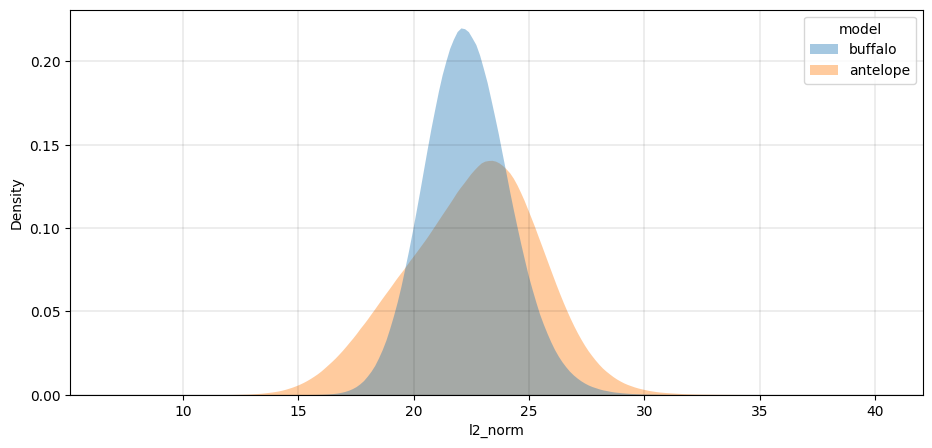

In [8]:
norm0 = list(map(np.linalg.norm, dataset_train.feats0))
norm1 = list(map(np.linalg.norm, dataset_train.feats1))

df = pd.DataFrame()
df['l2_norm'] = norm0 + norm1
df['model'] = ['buffalo' for i in range(len(norm0))] + ['antelope' for i in range(len(norm1))]

fig, ax = plt.subplots(figsize=(11,5))

plt.grid(color = 'black', linewidth = 0.1)
g = sns.kdeplot(
   data=df, x="l2_norm", hue="model",
   fill=True, common_norm=False, # palette="crest",
   alpha=.4, linewidth=0,
)

plt.show(g)

## Training

### Architecture selection

We have a hypothesis that there exists global optimal mutual arrangement of people in the latent space for all models. In this case transition to a new basis is enough which can be realised with a single Linear layer. Also we try more complex MLP architectures

In [14]:
cfg.num_epoch = 3
models = {
    'linear_wo_bias': torch.nn.Linear(cfg.embed_dim, cfg.embed_dim, bias=False),
    'linear': torch.nn.Linear(cfg.embed_dim, cfg.embed_dim),
    'mlp_1h_no_act_no_norm': torchvision.ops.MLP(cfg.embed_dim, [cfg.embed_dim], activation_layer=torch.nn.Identity),
    'mlp_1h_relu_act_no_norm': torchvision.ops.MLP(cfg.embed_dim, [cfg.embed_dim]),
    'mlp_1h_no_act_bn1d_norm': torchvision.ops.MLP(cfg.embed_dim, [cfg.embed_dim], norm_layer=torch.nn.BatchNorm1d, activation_layer=torch.nn.Identity),
    'mlp_1h_relu_act_bn1d_norm': torchvision.ops.MLP(cfg.embed_dim, [cfg.embed_dim], norm_layer=torch.nn.BatchNorm1d),
    'mlp_2h_no_act_no_norm': torchvision.ops.MLP(cfg.embed_dim, [cfg.embed_dim, cfg.embed_dim], activation_layer=torch.nn.Identity),

}

loss = torch.nn.MSELoss()


In [16]:
def run_train_epoch(model, opt, dataloader_train, scheduler=None, epoch=-1):
    loss_train = AverageMeter()
    model.train()
    for feats0, feats1 in tqdm(dataloader_train):
        feats0 = feats0.to(mps_device)
        feats1 = feats1.to(mps_device)
        
        pred = model(feats0)
        batch_loss = loss(pred, feats1)
        batch_loss.backward()
        loss_train.update(batch_loss.detach().cpu())
        opt.step()
        opt.zero_grad()
    if scheduler:
        scheduler.step()
    print(f'TRAIN EPOCH {epoch}: MSE {loss_train.avg}')


def run_val_epoch(model, dataloader_val, epoch=-1):
    loss_val = AverageMeter()
    cos_val = AverageMeter()
    cos = torch.nn.CosineSimilarity()
    cos_vals = []
    model.eval()
    for feats0, feats1 in tqdm(dataloader_val):
        feats0 = feats0.to(mps_device)
        feats1 = feats1.to(mps_device)
        with torch.no_grad():
            pred = model(feats0)
            batch_loss = loss(pred, feats1)
            batch_cos = cos(pred, feats1)
        cos_vals.extend(batch_cos.cpu().numpy().tolist())
        loss_val.update(batch_loss)
        cos_val.update(batch_cos.mean())
    print(f'VAL EPOCH {epoch}: MSE {loss_val.avg} | mean cos: {cos_val.avg}')

    return model, cos_vals

def run_epoch(model, opt, dataloader_train, dataloader_val, scheduler=None, epoch=-1):
    run_train_epoch(model, opt, dataloader_train, scheduler, epoch)
    run_val_epoch(model, dataloader_val, epoch)

In [11]:
for model_name, model in models.items():
    print(model_name)
    model.to(mps_device)
    opt = torch.optim.SGD(params=model.parameters(), lr=cfg.lr, momentum=0.9)
    model_trained = run_epoch(model, opt, dataloader_train, dataloader_val)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[i for i in range(0, cfg.num_epoch)], verbose=False)

linear_wo_bias


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:09<00:00, 16.21it/s]


TRAIN EPOCH -1: MSE 0.25992903113365173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:05<00:00, 17.20it/s]


VAL EPOCH -1: MSE 0.20691941678524017 | mean cos: 0.8960865139961243
linear


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:08<00:00, 16.33it/s]


TRAIN EPOCH -1: MSE 0.2592540383338928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.79it/s]


VAL EPOCH -1: MSE 0.20633502304553986 | mean cos: 0.8964141607284546
mlp_1h_no_act_no_norm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:09<00:00, 16.30it/s]


TRAIN EPOCH -1: MSE 0.2592402696609497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 19.65it/s]


VAL EPOCH -1: MSE 0.20635385811328888 | mean cos: 0.8964032530784607
mlp_1h_relu_act_no_norm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:10<00:00, 16.17it/s]


TRAIN EPOCH -1: MSE 0.2593415677547455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 19.50it/s]


VAL EPOCH -1: MSE 0.2062741219997406 | mean cos: 0.8964500427246094
mlp_1h_no_act_bn1d_norm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:09<00:00, 16.23it/s]


TRAIN EPOCH -1: MSE 0.2594585418701172


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.98it/s]


VAL EPOCH -1: MSE 0.206247478723526 | mean cos: 0.8964642286300659
mlp_1h_relu_act_bn1d_norm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:09<00:00, 16.32it/s]


TRAIN EPOCH -1: MSE 0.2593229413032532


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 19.03it/s]


VAL EPOCH -1: MSE 0.20630331337451935 | mean cos: 0.8964346051216125
mlp_2h_no_act_no_norm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [02:14<00:00, 15.61it/s]


TRAIN EPOCH -1: MSE 0.2750991880893707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.74it/s]

VAL EPOCH -1: MSE 0.20657895505428314 | mean cos: 0.896274983882904


## Training 

Linear layer turned out to be enough. For global optimum we will use OLS (averaged by sveral parts due to RAM restriction)

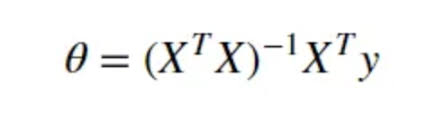

In [6]:
def analytical_solution(X, Y, bias=True):
    """
    Compute the analytical solution for the weights matrix A and bias vector b
    for the linear layer equation Y = X.dot(A) + b.
    
    Parameters:
    X : numpy array, shape (N, 512)
        Input feature matrix.
    Y : numpy array, shape (N, 512)
        Target matrix.
        
    Returns:
    A : numpy array, shape (512, 512)
        Weights matrix.
    b : numpy array, shape (1, 512)
        Bias vector.
    """
    N = X.shape[0]
    
    # Augment X with a column of ones to account for the bias term
    if bias:
        X = np.hstack((np.ones((N, 1)), X))
    
    # Normal equation to solve for the augmented weights
    W = np.linalg.lstsq(X, Y, rcond=None)[0]
    
    # Extract the bias and weights
    if bias:
        b = W[0, :]
        A = W[1:, :]
    else:
        b = None
        A = W
    return A, b

In [7]:
train_parts = {0: ['templatesgen_glint_0_10K.pkl', 
                  'templatesgen_glint_10K_20K.pkl',
                  'templatesgen_glint_20K_30K.pkl',
                  'templatesgen_glint_30K_40K.pkl',
                  'templatesgen_glint_40K_50K.pkl'
                  ],
               1: ['templatesgen_glint_50K_60K.pkl',
                   'templatesgen_glint_60K_70K.pkl',
                   'templatesgen_glint_70K_80K.pkl',
                   'templatesgen_glint_80K_90K.pkl',
                   'templatesgen_glint_90K_100K.pkl'
                  ],
               2: ['templatesgen_glint_140K_180K.pkl',
                   'templatesgen_glint_210K_220K.pkl'
                  ],
               3: ['templatesgen_glint_180K_200K.pkl',
                   'templatesgen_glint_200K_210K.pkl'
                  ]
              }
                 
test_parts = ['templatesgen_glint_220K_230K.pkl']    

In [8]:
dataset_val = Vect2VecDataset(cfg.data_root, test_parts, mode='val')
dataloader_val = DataLoader(dataset_val, batch_size=cfg.batch_size, shuffle=False)

VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


In [9]:
def validate(dataset_val, params):
    A, b = params
    pred = dataset_val.feats0.dot(A) + b.reshape(1, 512)
    mse = ((pred - dataset_val.feats1) **2).mean()
    cos = torch.nn.CosineSimilarity()(torch.from_numpy(pred), torch.from_numpy(dataset_val.feats1)).mean()

    return mse, cos 


def process_part(files_list, ph_per_id=None, max_ph=None):
    dataset_train = Vect2VecDataset(cfg.data_root, files_list, mode='train', ph_per_id=ph_per_id, max_ph=max_ph)
    dataset_val = Vect2VecDataset(cfg.data_root, test_parts, mode='val', ph_per_id=ph_per_id, max_ph=max_ph)
    A, b = analytical_solution(dataset_train.feats0, dataset_train.feats1)
    print(validate(dataset_val, (A, b)))

    return A, b


def export_model(A, b, name):
    model = torch.nn.Linear(cfg.embed_dim, cfg.embed_dim)
    w = model.state_dict()
    w['weight'] = torch.from_numpy(A).transpose(1, 0)
    w['bias'] = torch.from_numpy(b)
    model.load_state_dict(w)
    model.to(mps_device)
    loss = torch.nn.MSELoss()
    dataset_val = Vect2VecDataset(cfg.data_root, test_parts, mode='val')
    dataloader_val = DataLoader(dataset_val, batch_size=cfg.batch_size, shuffle=False)
    model, cos_vals = run_val_epoch(model, dataloader_val, epoch=-1)
    
    x = torch.randn(1, 512, requires_grad=False)
    x = x.to(mps_device)
    model.eval()
    torch_out = model(x)
    
    # Export the model
    torch.onnx.export(model,               # model being run
                      x,                         # model input (or a tuple for multiple inputs)
                      f"buffalo2antelope_adapter_{name}.onnx",   # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

    return cos_vals


In [10]:
results = []

for part in train_parts:
    params = process_part(train_parts[part])
    results.append(params)

TRAIN dataset: 
Unique UIDS: 50000 
Vector pairs: 2782828
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874
(0.19374546426230058, tensor(0.9033, dtype=torch.float64))
TRAIN dataset: 
Unique UIDS: 50000 
Vector pairs: 2495778
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874
(0.19368677109573876, tensor(0.9033, dtype=torch.float64))
TRAIN dataset: 
Unique UIDS: 50000 
Vector pairs: 2139964
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874
(0.19362566610908738, tensor(0.9034, dtype=torch.float64))
TRAIN dataset: 
Unique UIDS: 30000 
Vector pairs: 1207362
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874
(0.19465626861986074, tensor(0.9028, dtype=torch.float64))


In [18]:
A = np.stack([params[0] for params in results]).mean(axis=0)
b = np.stack([params[1] for params in results]).mean(axis=0)
val_cos = export_model(A, b, 'all_data')

VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 34.18it/s]


VAL EPOCH -1: MSE 0.19256280362606049 | mean cos: 0.9039458632469177
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



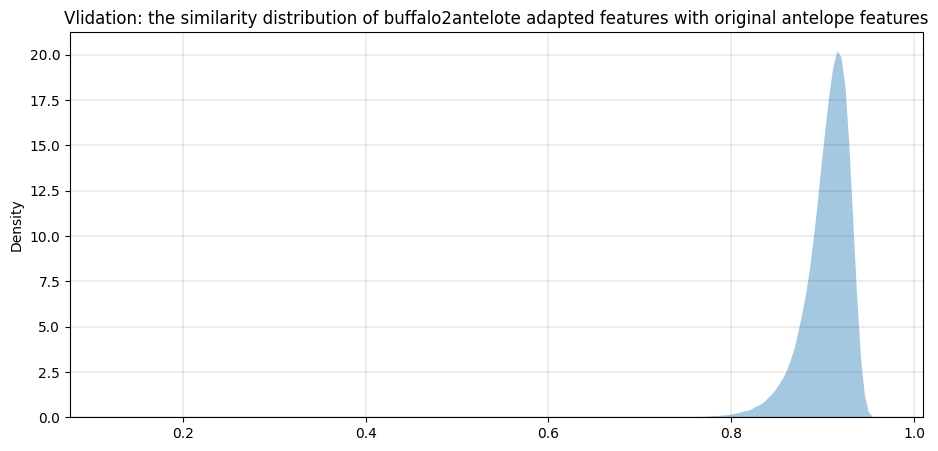

In [21]:
fig, ax = plt.subplots(figsize=(11,5))

plt.grid(color = 'black', linewidth = 0.1)
g = sns.kdeplot(
   data=val_cos,
   fill=True, common_norm=False, # palette="crest",
   alpha=.4, linewidth=0,
)
plt.title('Vlidation: the similarity distribution of buffalo2antelote adapted features with original antelope features')
plt.show(g)

## Experiments

Previously we trained with all data (~200k ids with >10m phs).
Now lets move to more realistic situation whrere limited database is stolen with only one photo per person, and find necessary number of vectors for adequate quality.

In [22]:
train_parts_by_size = {100: ['templatesgen_glint_0_10K.pkl'],
                       1000: ['templatesgen_glint_0_10K.pkl'],
                       10000: ['templatesgen_glint_0_10K.pkl'],
                       100000: ['templatesgen_glint_0_10K.pkl',
                               'templatesgen_glint_10K_20K.pkl',
                               'templatesgen_glint_20K_30K.pkl',
                               'templatesgen_glint_30K_40K.pkl',
                               'templatesgen_glint_40K_50K.pkl',
                               'templatesgen_glint_50K_60K.pkl',
                               'templatesgen_glint_60K_70K.pkl',
                               'templatesgen_glint_70K_80K.pkl',
                               'templatesgen_glint_80K_90K.pkl',
                               'templatesgen_glint_90K_100K.pkl'
                       ]
                       }

In [23]:
cos_distr_dict = {}

for part in train_parts_by_size:
    A, b = process_part(train_parts_by_size[part], 1, part)
    cos_vals = export_model(A, b, part)
    cos_distr_dict[part] = cos_vals

TRAIN dataset: 
Unique UIDS: 100 
Vector pairs: 100
VAL dataset: 
Unique UIDS: 100 
Vector pairs: 100
(0.8344655252744826, tensor(0.4661, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 36.23it/s]


VAL EPOCH -1: MSE 0.8223060369491577 | mean cos: 0.4517739713191986
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

TRAIN dataset: 
Unique UIDS: 1000 
Vector pairs: 1000
VAL dataset: 
Unique UIDS: 1000 
Vector pairs: 1000
(0.387483161477883, tensor(0.8171, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 34.51it/s]


VAL EPOCH -1: MSE 0.3942187428474426 | mean cos: 0.8111485838890076
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

TRAIN dataset: 
Unique UIDS: 10000 
Vector pairs: 10000
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 10000
(0.198603503818432, tensor(0.9028, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 35.11it/s]


VAL EPOCH -1: MSE 0.20489375293254852 | mean cos: 0.8972924947738647
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

TRAIN dataset: 
Unique UIDS: 100000 
Vector pairs: 100000
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 10000
(0.18881267074618244, tensor(0.9080, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 33.24it/s]


VAL EPOCH -1: MSE 0.19529838860034943 | mean cos: 0.9024257659912109
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



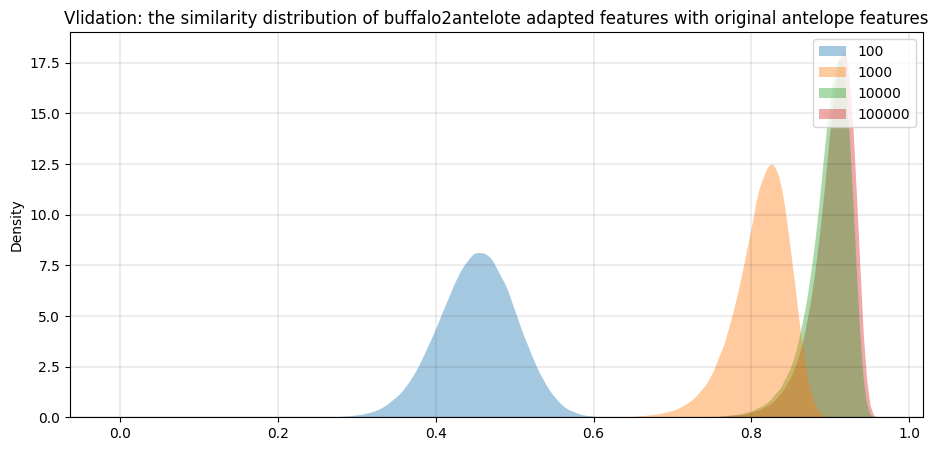

In [34]:
fig, ax = plt.subplots(figsize=(11,5))

plt.grid(color = 'black', linewidth = 0.1)
g = sns.kdeplot(
   data=cos_distr_dict,#df, x="cos", hue="model",
   fill=True, common_norm=False, # palette="crest",
   alpha=.4, linewidth=0
)
# plt.legend(title='N train vectors')
plt.title('Vlidation: the similarity distribution of buffalo2antelote adapted features with original antelope features')

plt.show(g)

### 10k ids seems to be enough, but we should check recunstruction results and similarity scores

In [32]:
train_parts_by_size = {100: ['high_quality.pickle'],
                       1000: ['high_quality.pickle'],
                       4000: ['high_quality.pickle']
                       }

cos_distr_dict_hq = {}
for part in train_parts_by_size:
    A, b = process_part(train_parts_by_size[part], 1, part)
    cos_vals = export_model(A, b, f'HQ_{part}')
    cos_distr_dict_hq[part] = cos_vals

TRAIN dataset: 
Unique UIDS: 100 
Vector pairs: 100
VAL dataset: 
Unique UIDS: 100 
Vector pairs: 100
(0.835396177249485, tensor(0.4623, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:03<00:00, 28.74it/s]


VAL EPOCH -1: MSE 0.8132529258728027 | mean cos: 0.45666274428367615
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

TRAIN dataset: 
Unique UIDS: 1000 
Vector pairs: 1000
VAL dataset: 
Unique UIDS: 1000 
Vector pairs: 1000
(0.4917181208695631, tensor(0.7682, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 33.62it/s]


VAL EPOCH -1: MSE 0.4821140468120575 | mean cos: 0.7691298723220825
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

TRAIN dataset: 
Unique UIDS: 4000 
Vector pairs: 4000
VAL dataset: 
Unique UIDS: 4000 
Vector pairs: 4000
(0.2722044732555119, tensor(0.8633, dtype=torch.float64))
VAL dataset: 
Unique UIDS: 10000 
Vector pairs: 373874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 33.85it/s]


VAL EPOCH -1: MSE 0.26875826716423035 | mean cos: 0.8622453808784485
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



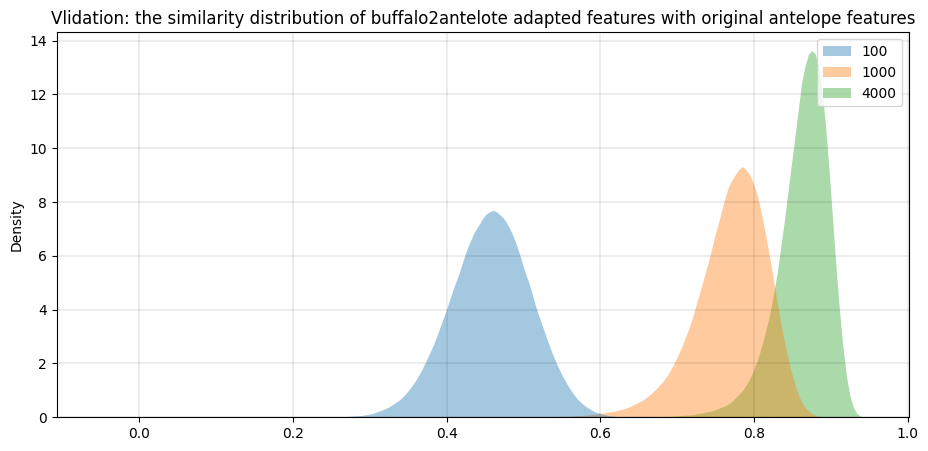

In [35]:
fig, ax = plt.subplots(figsize=(11,5))

plt.grid(color = 'black', linewidth = 0.1)
g = sns.kdeplot(
   data=cos_distr_dict_hq,#df, x="cos", hue="model",
   fill=True, common_norm=False, # palette="crest",
   alpha=.4, linewidth=0
)
# plt.legend(title='N train vectors')
plt.title('Vlidation: the similarity distribution of buffalo2antelote adapted features with original antelope features')

plt.show(g)